# IMPORTS

In [32]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from numba import jit
import numpy as np
from scipy import optimize
import pickle

import sys 
sys.path.append("C:\\Work\\Fast-Navier-Stokes") #tell where to look for package
#import MyPackages.periodicnumerics as num
#from importlib import reload
#reload(num) #make sure any changes have been loaded in, useful if modifying while running

#random number gen
rng = np.random.default_rng()

Current Boundary Conditions:
- Initial Velocities
- Pressure at bounds
- d^2/dx^2 u = d^2/dy^2 u = 0 (consistent gradients)
  - may be better to use d/dx = d/dy = 0

# CODE

## NUMERICS DISCRETIZATIONS

In [127]:
@jit(nopython = True)
def Centerize(u,v): #get cell-center values from cell-face values for x and y components of a velocity vector
    return (u[1:] + u[:-1])/2, (v[:,1:] + v[:,:-1])/2

@jit(nopython = True)
def xdivc_c(u): #calculate x derivative of cell-center defined field, center diff
    dudx = np.zeros((Nx,Ny)) #initialize return array
    
    dudx[1:-1] = (u[2:] - u[:-2])/(2*dx) #fill in non-edge values
    dudx[0] = (u[1] - u[0])/dx #left edge (assume consistent gradient at bnd)
    dudx[-1] = (u[-1] - u[-2])/dx #right edge (assume consistent gradient at bnd)
    
    return dudx

@jit(nopython = True)
def ydivc_c(u): #calculate y derivative of cell-center defined field, center diff
    dudy = np.zeros((Nx,Ny)) #initialize return array
    
    dudy[:,1:-1] = (u[:,2:] - u[:,:-2])/(2*dy) #fill in non-edge values
    dudy[:,0] = (u[:,1] - u[:,0])/dy #bottom edge (assume consistent gradient at bnd)
    dudy[:,-1] = (u[:,-1] - u[:,-2])/dy #top edge (assume consistent gradient at bnd)
    
    return dudy

@jit(nopython = True)
def get_curl(u,v,dx,dy): #calculate approximate curl of velocity field. #input velocities defined at cell bnds, return curls at (interior) cell vertices. #x velocity (u), y velocity (v)
    return (v[1:,1:-1] - v[:-1,1:-1])/dx - (u[1:-1,1:] - u[1:-1,:-1])/dy

@jit(nopython = True)
def get_div(u,v,dx,dy): #calculate approximate divergence of velocity field. #input velocities defined at cell bnds, return divergences at cell centers. #x velocity (u), y velocity (v)
    dudx, dvdy = (u[1:] - u[:-1])/dx, (v[:,1:] - v[:,:-1])/dy #velocity gradient components
    return dudx + dvdy

@jit(nopython=True)
def LoopIntegral(dudt, dvdt, dx, dy): #loop-integrate accelerations from a given solution
    loopint = np.zeros((Nx+1,Ny+1)) #init array of loop integrals calculated around each vertex

    #corner cases
    loopint[0,0] = (dvdt[0,0]*dy - dudt[0,0]*dx)/2 #bottom-left corner
    loopint[-1,0] = -(dudt[-1,0]*dx + dvdt[-1,0]*dy)/2 #bottom-right corner
    loopint[0,-1] = (dudt[0,-1]*dx + dvdt[0,-1]*dy)/2 #top-left corner
    loopint[-1,-1] = (dudt[-1,-1]*dx - dvdt[-1,-1]*dy)/2 #top-right corner
    #edge cases
    loopint[0,1:-1] = (dudt[0,:-1] - dudt[0,1:])*dx/2 + dvdt[0,1:-1]*dy #left edge
    loopint[-1,1:-1] = (dudt[-1,:-1] - dudt[-1,1:])*dx/2 - dvdt[-1,1:-1]*dy #right edge
    loopint[1:-1,0] = (dvdt[1:,0] - dvdt[:-1,0])*dy/2 - dudt[1:-1,0]*dx #bottom edge
    loopint[1:-1,-1] = (dvdt[1:,-1] - dvdt[:-1,-1])*dy/2 + dudt[1:-1,-1]*dx #top edge
    #main case
    loopint[1:-1,1:-1] = (dudt[1:-1,:-1] - dudt[1:-1,1:])*dx + (dvdt[1:,1:-1] - dvdt[:-1,1:-1])*dy #get_curl(u,v,dx,dy)*dx*dy
    
    return loopint

@jit(nopython=True)
def LoopVelocities(loopint,dx,dy): #back-out a 

## PDE FUNCTIONS

In [128]:
#@jit(nopython=True)
def ViscForces_c(u_c, v_c): #calculate x and y components of viscous forces at cell centers #input cell-center values of velocities
    Fvisc_x, Fvisc_y = np.zeros((Nx,Ny)), np.zeros((Nx,Ny)) #placeholder
    return Fvisc_x, Fvisc_y

@jit(nopython=True)
def DragForces_c(u_c, v_c): #calculate x and y components of a simple square-law drag (imagine plates above and below the 2-D plane) at cell centers #input cell-center values of velocities
    mag_c = np.sqrt(u_c**2 + v_c**2) #velocity vector magnitude
    return -C_D*u_c*mag_c, -C_D*v_c*mag_c #drag force density components. in opposition to direction of velocity, with vel*2 as magnitude

#@jit(nopython=True)
def LineEquationsFNS_old(u, v, u_c, v_c, dudt_pre, dvdt_pre, P_lb, P_rb, P_bb, P_tb): #get time derivatives of the velocities according to the line equations using, effectively, a pre-assumed divergence field
    
    ddx_dudt, ddy_dvdt = (dudt_pre[1:] - dudt_pre[:-1])/dx, (dvdt_pre[:,1:] - dvdt_pre[:,:-1])/dy #get x div of previous iteration dudt's, y div of dvdt's at cell centers
    dDdt_x, dDdt_y =  -np.cumsum(ddy_dvdt, axis=0)*dx, -np.cumsum(ddx_dudt, axis=1)*dy #bound-to-point deltas along x (for u) lines and y (for v) lines respectively. From divergence = 0 formula.
    #print(dDdt_x)

    adv_x_x, adv_y_y = (u[-1]**2 - u[0]**2)/2, (v[:,-1]**2 - v[:,0]**2)/2 #self-advection (integrated over channel)
    #print(adv_x_x, adv_y_y)
    adv_x_y, adv_y_x = v_c*ydivc_c(u_c), u_c*xdivc_c(v_c) #cross-advection (per node)

    Fvisc_x, Fvisc_y = ViscForces_c(u_c, v_c) #viscous forces
    Fdrag_x, Fdrag_y = DragForces_c(u_c, v_c) #simple drag forces
    F_x, F_y = Fvisc_x + Fdrag_x, Fvisc_y + Fdrag_y #summed forces
    
    dudt_lb, dvdt_bb = (np.sum(F_x - adv_x_y, axis=0)*dx - adv_x_x + P_lb - P_rb - np.sum(dDdt_x, axis=0)*dx)/lx, (np.sum(F_y - adv_y_x, axis=1)*dy - adv_y_y + P_bb - P_tb - np.sum(dDdt_y, axis=1)*dy)/ly #integral method to calculate left bnd u, bottom bnd v 
 
    dudt_line, dvdt_line = np.append([dudt_lb], dDdt_x + dudt_lb, axis=0), np.swapaxes(np.append([dvdt_bb], dDdt_y + dvdt_bb, axis=0), 0,1) #re-add deltas
    
    return dudt_line, dvdt_line #return line-eq velocities

#@jit(nopython=True)
def LineEquationsFNS(u, v, u_c, v_c, dudt_pre, dvdt_pre, P_lb, P_rb, P_bb, P_tb): #get time derivatives of the velocities according to the line equations using, effectively, a pre-assumed divergence field
    
    ddx_dudt, ddy_dvdt = (dudt_pre[1:] - dudt_pre[:-1])/dx, (dvdt_pre[:,1:] - dvdt_pre[:,:-1])/dy #get x div of previous iteration dudt's, y div of dvdt's at cell centers
    dDdt_x, dDdt_y =  -np.cumsum(ddy_dvdt, axis=0)*dx, -np.cumsum(ddx_dudt, axis=1)*dy #bound-to-point deltas along x (for u) lines and y (for v) lines respectively. From divergence = 0 formula.
    #print(dDdt_x)

    adv_x_x, adv_y_y = (u[-1]**2 - u[0]**2)/2, (v[:,-1]**2 - v[:,0]**2)/2 #self-advection (integrated over channel)
    #print(adv_x_x, adv_y_y)
    adv_x_y, adv_y_x = v_c*ydivc_c(u_c), u_c*xdivc_c(v_c) #cross-advection (per node)

    Fvisc_x, Fvisc_y = ViscForces_c(u_c, v_c) #viscous forces
    Fdrag_x, Fdrag_y = DragForces_c(u_c, v_c) #simple drag forces
    F_x, F_y = Fvisc_x + Fdrag_x, Fvisc_y + Fdrag_y #summed forces
    
    dudt_lb, dvdt_bb = (np.sum(F_x - adv_x_y, axis=0)*dx - adv_x_x + P_lb - P_rb - np.sum(dDdt_x, axis=0)*dx)/lx, (np.sum(F_y - adv_y_x, axis=1)*dy - adv_y_y + P_bb - P_tb - np.sum(dDdt_y, axis=1)*dy)/ly #integral method to calculate left bnd u, bottom bnd v 
 
    dudt_line, dvdt_line = np.append([dudt_lb], dDdt_x + dudt_lb, axis=0), np.swapaxes(np.append([dvdt_bb], dDdt_y + dvdt_bb, axis=0), 0,1) #re-add deltas
    
    return dudt_line, dvdt_line #return line-eq velocities

#@jit(nopython=True)
def LoopEquationsFNS(u, v, u_c, v_c, P_lb, P_rb, P_bb, P_tb):
    loopforce = np.zeros((Nx+1,Ny+1)) #init array of loop forces calculated around each vertex
    
    #corner cases
    loopforce[0,0] = P_bb[0] - P_lb[0] #bottom-left corner #ADD FORCE AND ADVECTION TERMS
    loopforce[-1,0] = P_rb[0] - P_bb[-1] #bottom-right corner
    loopforce[0,-1] = P_lb[-1] - P_tb[0] #top-left corner
    loopforce[-1,-1] = P_tb[-1] - P_rb[-1] #top-right corner
    #edge cases
    loopforce[0,1:-1] = P_lb[:-1] - P_lb[1:] #left edge #ADD FORCE AND ADVECTION TERMS
    loopforce[-1,1:-1] =  P_rb[1:] -  P_rb[:-1] #right edge
    loopforce[1:-1,0] = P_bb[1:] - P_bb[:-1] #bottom edge
    loopforce[1:-1,-1] = P_tb[:-1] - P_tb[1:] #top edge
    #main case
    loopforce[1:-1,1:-1] = 0 #ADD FORCE AND ADVECTION TERMS
    
    return loopforce

#@jit(nopython=True)
def IteratorFNS(u, v, dudt_prev, dvdt_prev, P_lb, P_rb, P_bb, P_tb): #run multiple iterations until tolerance threshold reached
    intol = False #init in-tolerance marker
    dudt_pre, dvdt_pre = dudt_prev, dvdt_prev #set last timestep values as first "guess" pre-values
    itercount = 0 #number of iterations (for debugging)
    
    eqloop = LoopEquationsFNS(u, v, u_c, v_c, P_lb, P_rb, P_bb, P_tb) #solve the loop integrated momentum equations (these don't change from iteration to iteration
    
    while not intol and itercount < 100: #if not already in tolerance (or past max iterations), iterate
        u_c, v_c = Centerize(u, v) #get cell-center averages of the last-timestep velocities
        dudt_line, dvdt_line = LineEquationsFNS(u, v, u_c, v_c, dudt_pre, dvdt_pre, P_lb, P_rb, P_bb, P_tb) #solve the straight-line integrated momentum equations
        lineloop = LoopIntegral(dudt_line, dvdt_line, dx, dy) #find the loop integrals of the LineEquation solution
        
        diff_loop = lineloop - eqloop #find the difference in the loop acceleration integrals
        loop_corr = 
        
        iterdiff_u, iterdiff_v = np.abs(dudt_post - dudt_pre), np.abs(dvdt_post - dvdt_pre) #abs difference in velocity divs vs. last iteration
        totaldiff_u, totaldiff_v = np.abs(dudt_post - dudt_prev), np.abs(dvdt_post - dvdt_prev) #abs difference in velocity divs vs. last timestep
        #print(np.max(iterdiff_u))
        #print(np.max(iterdiff_v))
        
        if np.max(iterdiff_u/(totaldiff_u+1e-12)) < tol and np.max(iterdiff_v/(totaldiff_v+1e-12)) < tol: #check if in tolerance
            intol = True #mark as in tolerance

        dudt_pre, dvdt_pre = dudt_post, dvdt_post #push back values to "pre" for next iteration
        itercount+=1 #add to number of iterations (for debugging)

    if itercount >= 100:
        print('Broken')

    return dudt_post, dvdt_post #once in tolerance, return final values
    
#@jit(nopython=True)
def NextTimeStepFNS(u, v, dudt_prev, dvdt_prev, P_lb, P_rb, P_bb, P_tb): #midpoint method to march velocities forward in time.
    dudt_0, dvdt_0 = IteratorFNS(u, v, dudt_prev, dvdt_prev, P_lb, P_rb, P_bb, P_tb) #solve for time divs based on intial values
    u_mid, v_mid = u + dudt_0*dt/2, v + dvdt_0*dt/2 #get midpoint values

    dudt_mid, dvdt_mid = IteratorFNS(u_mid, v_mid, dudt_0, dvdt_0, P_lb, P_rb, P_bb, P_tb) #solve for time divs based on midpoint values #using midpoint timedivs only as pre-iteration guesses and to gauge tolerance
    u_new, v_new = u + dudt_mid*dt, v + dvdt_mid*dt #get final values
    
    return u_new, v_new, dudt_mid, dvdt_mid #return final values and time derivatives (to be used as guesses + for determining if in tolerance)

## RUN FUNCTION

In [83]:
def RunFNS(tend, dt, P_lb, P_rb, P_bb, P_tb, init_cond):
    global ntimesteps
    
    ntimesteps = round(tend/dt) #number of timesteps
    print(f'ntimesteps \n{ntimesteps}\n') #output the number of timesteps to be run

    #if shortmemory: #if only one timestep to be kept #FOR LATER WHEN I'M NOT DEBUGGING
    #else: #if all timesteps to be kept
    
    #initialize arrays for data, ntimesteps x Nx(+1) x Ny(+1)
    u, v, dudt, dvdt = np.zeros((ntimesteps,Nx+1,Ny)), np.zeros((ntimesteps,Nx,Ny+1)), np.zeros((ntimesteps,Nx+1,Ny)), np.zeros((ntimesteps,Nx,Ny+1)) #face velocities, time derivatives
    
    #load initial conditions
    u[0], v[0], dudt[0], dvdt[0] = init_cond
    
    #run the code, iterating timesteps
    for i in range(1,ntimesteps):
        u[i], v[i], dudt[i], dvdt[i] = NextTimeStepFNS(u[i-1],v[i-1],dudt[i-1],dvdt[i-1], P_lb, P_rb, P_bb, P_tb) #set new variable values after a timestep #get time derivatives to be used as guesses + for determining tolerance
        if np.any(np.isnan(u[i])) | np.any(np.isnan(v[i])): #break if blown up
            print(f'Blowup at timestep {i}, t = {i*dt:.5}')
            break
        if i%10000 == 0: #output progress every 10000 timesteps
            print('timestep: ' + str(i))
    
    return u, v, dudt, dvdt

# INPUT DECK

In [105]:
lx, ly = 0.01, 0.01 #dimensions of simulation box in m, m
nu = 1e-5 #kinematic viscosity in m/s^2
C_D = 100.*1 #drag coefficient (really divided by a flow sheet height) in m^-1

#numerical parameters
Nx, Ny = 5, 5 #number of nodes each side
dx, dy = lx/Nx, ly/Ny #dimensions of each node
v_Co = 10 #Courant velocity (dx/dt) in m/s
dt = min(dx, dy)/v_Co #timestep in s
print(f'Timestep: {dt:.2}s')
tol = 1e-6 #tolerance of iterator (acceptable ratio of timediv diffs between iterations over diffs w.r.t. last timestep)
shortmemory = False #whether to keep all data (False) or just last timestep (True)

Timestep: 0.0002s


# BOUNDARY CONDITIONS

In [106]:
P_lb, P_rb = np.linspace(0,9.9,Ny), np.linspace(9.9,0,Ny) #x-boundary pressures (left, right)
P_bb, P_tb = np.linspace(0,9.9,Nx), np.linspace(9.9,0,Nx) #y-boundary pressures (bottom, top)

## SAVE BC's

In [107]:
savedict = {
    'P_lb' : P_lb,
    'P_rb' : P_rb,
    'P_bb' : P_bb,
    'P_tb' : P_tb
}

#with open('saveBC_test.pkl', 'wb') as f:
    #pickle.dump(savedict, f)

## LOAD BC's

In [108]:
with open('saveBC_test.pkl', 'rb') as f: #_vortex
    savedict = pickle.load(f)

P_lb, P_rb = savedict['P_lb'], savedict['P_rb']
P_bb, P_tb = savedict['P_bb'], savedict['P_tb']

# INITIAL CONDITIONS

SET BASE INITIAL CONDITIONS

In [122]:
u0 = np.ones((Nx+1,Ny))*.1 #velocity in x direction, at horizontal cell faces
v0 = np.zeros((Nx,Ny+1)) #velocity in y direction, at vertical cell faces

#u0[-1,0] += 0.01 #add small gradients at bottom right corner (0div)
#v0[-1,0] += 0.01

u0[3,3] += 1 #add a 4-face vortex loop (0 div)
u0[3,4] -= 1
v0[3,4] += 1
v0[2,4] -= 1

#P0 = np.zeros((Nx,Ny)) #pressure #doing this for now because the initial pressure doesn't actually matter now. Can try doing a simple Laplace solver on the BC's as an upgrade.
dudt0, dvdt0 = np.zeros((Nx+1,Ny)), np.zeros((Nx,Ny+1)) #0.1*(rng.random((Nx+1,Ny))-0.5), 0.1*(rng.random((Nx,Ny+1))-0.5) #guess time derivatives as 0 to start with
#dudt0[3,3] += 0.1 #add a 4-face vortex loop (0 div)
#dudt0[3,4] -= 0.1
#dvdt0[3,4] += 0.1
#dvdt0[2,4] -= 0.1

init_cond0 = [u0, v0, dudt0, dvdt0] #packed list of initial conditions

In [124]:
np.max(np.abs(get_div(u0,v0,dx,dy)))

0.0

SAVE LAST TIME STEP DATA AS INITIAL CONDITION

In [112]:
if shortmemory:
    init_cond1 = [u, v, dudt, dvdt]
else:
    init_cond1 = [u[-1], v[-1], dudt[-1], dvdt[-1]]

# RUN

In [113]:
tend = 0*0.1 + 1*dt #simulated time in seconds
print(f'End time: {tend:.3f}s')
ic = init_cond0 #initial conditions to be used
u, v, dudt, dvdt = RunFNS(tend, dt, P_lb, P_rb, P_bb, P_tb, ic)

End time: 0.000s
ntimesteps 
1



In [114]:
ts = -1 #timestep
#print(u[-1])
print(np.flip(np.swapaxes(u[ts][:5,:5],0,1),0))
#print(v[-1])
print(np.flip(np.swapaxes(v[ts][:5,:5],0,1),0))
div = get_div(u[ts],v[ts],dx,dy)
print(f'Divergence:\n {div}')
print(f'Max divergence = {np.max(div)}')

[[ 0.1  0.1  0.1 -0.9  0.1]
 [ 0.1  0.1  0.1  1.1  0.1]
 [ 0.1  0.1  0.1  0.1  0.1]
 [ 0.1  0.1  0.1  0.1  0.1]
 [ 0.1  0.1  0.1  0.1  0.1]]
[[ 0.  0. -1.  1.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Divergence:
 [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Max divergence = 0.0


In [115]:
get_curl(u[ts],v[ts],dx,dy)

array([[   0.,    0.,    0.,    0.],
       [   0.,    0.,    0., -500.],
       [   0.,    0., -500., 2000.],
       [   0.,    0.,    0., -500.]])

In [119]:
loopy = LoopIntegral(u[ts],v[ts])/dx/dy

In [120]:
np.flip(np.swapaxes(loopy,0,1),0)

array([[  25.,   50.,   50., -450.,   50.,   25.],
       [   0.,    0., -500., 2000., -500.,    0.],
       [   0.,    0.,    0., -500.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.],
       [ -25.,  -50.,  -50.,  -50.,  -50.,  -25.]])

In [117]:
LoopIntegral(u[ts],v[ts])[1:-1,1:-1]/dx/dy - get_curl(u[ts],v[ts],dx,dy)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

# VELOCITY PLOT

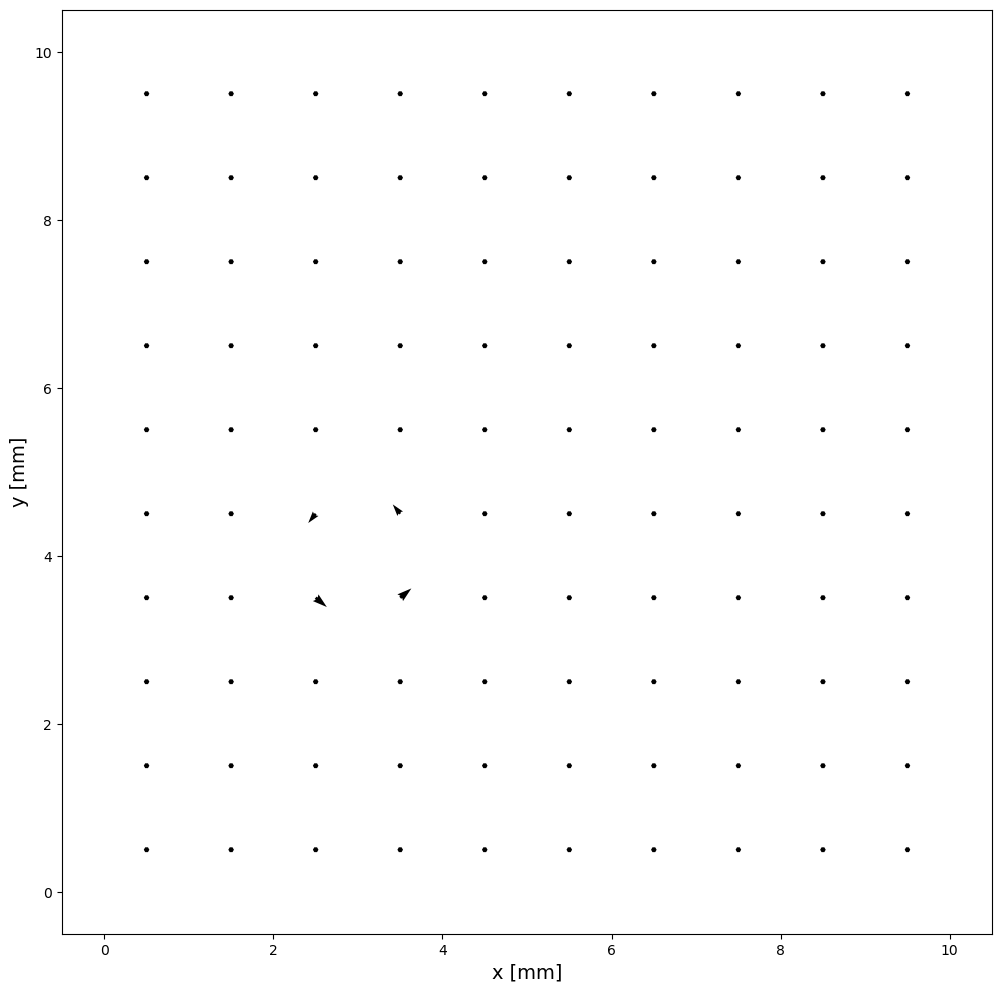

In [92]:
ts = -1 #timestep

thinning = 1 #how much to prune dataset #int
xs, ys = np.linspace(dx/2, lx - dx/2, round(Nx/thinning))*1000, np.linspace(dy/2, ly - dy/2, round(Ny/thinning))*1000
Y, X = np.meshgrid(xs,ys) #why do I have to switch this? The world may never know.
u_c, v_c = centerize(u[ts],v[ts]) #centerize
u_c, v_c = u_c[::thinning,::thinning], v_c[::thinning,::thinning] #thin-out

fig, ax = plt.subplots(figsize = (12,12))
ax.set_xlim([-dx/2*1000,(lx + dx/2)*1000])
ax.set_ylim([-dy/2*1000,(ly + dy/2)*1000])
ax.quiver(X, Y, u_c, v_c, scale = 50)
ax.set_xlabel('x [mm]', fontsize = 14)
ax.set_ylabel('y [mm]', fontsize = 14)
#ax.quiverkey(q, X=0.005, Y=0.005, U=10,label='Quiver key, length = 10', labelpos='E')

plt.show()

# MOVIES

In [ ]:
def MoviePlot(u, v, ts):
    fig = plt.figure(figsize = (12,12), num = 1, clear = 'True')
    ax = fig.add_subplot(111)

    fig.text(0.72,0.95, f'Time: {dt*ts:.4f} s', fontsize = 14, fontweight = 'bold')
    
    thinning = 5 #how much to prune dataset #int
    xs, ys = np.linspace(dx/2, lx - dx/2, round(Nx/thinning))*1000, np.linspace(dy/2, ly - dy/2, round(Ny/thinning))*1000
    Y, X = np.meshgrid(xs,ys) #why do I have to switch this? The world may never know.
    u_c, v_c = centerize(u,v) #centerize
    u_c, v_c = u_c[::thinning,::thinning], v_c[::thinning,::thinning] #thin-out
    
    ax.set_xlim([-dx/2*1000,(lx + dx/2)*1000])
    ax.set_ylim([-dy/2*1000,(ly + dy/2)*1000])
    ax.quiver(X, Y, u_c, v_c, scale = 50)
    ax.set_xlabel('x [mm]', fontsize = 14)
    ax.set_ylabel('y [mm]', fontsize = 14)
        
    plt.savefig('Pictures+Movies/MovieDump/frame' + str(ts) + '.png')
    plt.close()

In [ ]:
#save frames from long memory all at once
fps = 3000 #desired frames per second (reproduced approximately)
interval = int(np.ceil(1/fps/dt)) #number of timesteps skipped every frame to approximately reproduce desired fps
ntmod = ntimesteps - ntimesteps%interval #largest number of timesteps that can be evenly divided by the interval
frames = np.linspace(interval, ntmod-interval, int(ntmod/interval), dtype=int) #timesteps to be used as frames. Start at 'interval', not 0, because RunTFM() does not iterate timestep 0

for ts in frames: #plot and save figures at the timesteps in 'frames'
     MoviePlot(u[ts], v[ts], ts)

# MISC

## Set arrays automatically or manually? (answer: 100% automatically)

In [ ]:
arr = rng.random((Nx+1,Ny))
np.shape(arr[:,1:])

In [ ]:
@jit(nopython=True)
def cutarray_numpy(arr):
    cutarr = arr[1:][:]
    return cutarr

In [ ]:
@jit(nopython=True)
def cutarray_manual(arr):
    shape = np.shape(arr) #get initial shape
    cutarr = np.zeros((shape[0]-1,shape[1])) #init cut arr
    for i in range(shape[0]-1): #fill
        for j in range(shape[1]):
            cutarr[i][j] = arr[i+1][j]
    cutarr = arr[1:][:]
    return cutarr

In [ ]:
#%%timeit
cutarr0 = cutarray_numpy(arr)

In [ ]:
#%%timeit
cutarr1 = cutarray_manual(arr)

In [ ]:
# WAY SLOWER TO DO THIS MANUALLY

In [ ]:
np.all(cutarr0 == cutarr1)

## Coordinate representation

In [ ]:
arr = np.zeros((10,10))
for i in range(len(arr)):
    arr[i] = np.arange(10)
arr2 = np.cumsum(arr,axis = 0)
arr2

In [ ]:
np.flip(np.swapaxes(arr2,0,1),0) #Cartesian redisplay

### Summing and Appending

In [ ]:
np.cumsum(arr2, axis = 1)

In [ ]:
np.sum(np.cumsum(arr2, axis = 1), axis = 1)

In [ ]:
np.append([np.arange(3)], np.zeros((3,3)), axis = 0)

In [ ]:
yarr = np.swapaxes(np.append([np.arange(3)], np.zeros((3,3)), axis = 0),0,1)

In [ ]:
np.flip(np.swapaxes(yarr,0,1),0)

## Derivatives

In [ ]:
arr = np.zeros((10,10))
for i in range(len(arr)):
    arr[i] = -np.arange(10) - i
arr

In [ ]:
xdivc_c(arr)